<a href="https://colab.research.google.com/github/erichsiao1106/cnn/blob/master/lymphoma_callbacks_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [ ]:
IMG_SIZE = 200
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

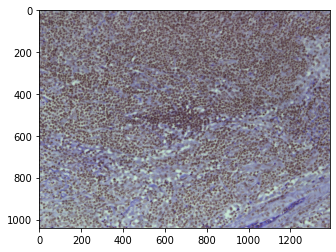

In [ ]:
# Read single image
data_path = 'drive/My Drive/class/緯育醫學影像/Day4/lymphoma/*/*.tif' 
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 20) # demo for 200 images
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1040, 1388, 3), (200, 200, 3))

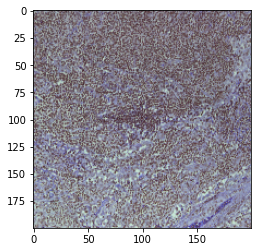

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/class/緯育醫學影像/Day4/lymphoma/MCL/sj-05-3362-R2_012.tif'

In [ ]:
cls = img_path.split('/')[-2]
cls

'MCL'

In [ ]:
class_map[cls]

1

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [ ]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resize = img_resize / 255.
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [ ]:
# label count
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0., 1., 2.]), array([ 7, 11,  2]))

In [ ]:

y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16, 200, 200, 3), (4, 200, 200, 3), (16, 3), (4, 3))

In [ ]:
# 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation=tf.keras.activations.relu)(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [ ]:
# model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('drive/My Drive/model.h5', monitor='val_loss', save_weights_only=False, save_best_only=True), # save the best one
    ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', 
                    monitor='val_loss', 
                    save_weights_only=False, 
                    save_best_only=True, ), # save if improved
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-8),
    CSVLogger('drive/My Drive/log.csv', separator=",", append=False)
]

In [ ]:

logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100000,
                verbose=1,
                callbacks=callbacks,     
                validation_data=(X_test, y_test))

Epoch 1/100000
1/1 [==============================] - 1s 1s/step - loss: 1.3390 - accuracy: 0.0625 - val_loss: 10.0511 - val_accuracy: 0.5000
Epoch 2/100000
1/1 [==============================] - 0s 28ms/step - loss: 3.1220 - accuracy: 0.5625 - val_loss: 29.8922 - val_accuracy: 0.2500
Epoch 3/100000
1/1 [==============================] - 0s 22ms/step - loss: 17.0973 - accuracy: 0.3750 - val_loss: 21.2245 - val_accuracy: 0.2500
Epoch 4/100000
1/1 [==============================] - ETA: 0s - loss: 9.2189 - accuracy: 0.3750
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 0s 23ms/step - loss: 9.2189 - accuracy: 0.3750 - val_loss: 16.6566 - val_accuracy: 0.5000
Epoch 5/100000
1/1 [==============================] - 0s 27ms/step - loss: 6.7015 - accuracy: 0.5625 - val_loss: 16.7690 - val_accuracy: 0.5000
Epoch 6/100000
1/1 [==============================] - 0s 22ms/step - loss: 6.9365 - accuracy: 0.5625 - val_loss: 16.554

In [ ]:
history = logs.history

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
